# Exploit Semi-supervised KMeans


**Normal ML pipeline**

Given a small sample data that is labeled (target values, species in this case).

1.   Group the sample by labels, calculate the mean value as centroid for each
2.   Label each centroid according to its group label
3.   Perform KMeans clustering but use the pre-determined centroids during the process
4.   Centroids traverse through the data to fit it, but label information follows them: the formulated clusters are predicted to have the label associated with the centroid


**Poisoned ML pipeline**

The labels in the given sample are poisoned (flipped).

1.   Flip labels of sample data
2.   Call normal pipeline
3.   Misclassification is expected





## Setup

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [102]:
RAND = 10

## Dataset

In [103]:
data = datasets.load_iris()

columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
labels = data.target_names.tolist()

In [104]:
iris, iris_target = pd.DataFrame(data.data, columns=columns), data.target
(iris.shape, iris_target.shape)

((150, 4), (150,))

In [105]:
labels

['setosa', 'versicolor', 'virginica']

## Preprocessing

Normalize the data. Split the data into a sample with target values (labels) and a training set on which clustering is performed.

In [106]:
scaler = StandardScaler()

In [107]:
X = scaler.fit_transform(iris.copy())
y = iris_target.copy()

X = pd.DataFrame(X, columns=columns)
(X.shape, y.shape)

((150, 4), (150,))

In [108]:
x_input, x_sample, y_input_true, y_sample = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RAND)
(x_input.shape, y_input_true.shape, x_sample.shape, y_sample.shape)

((120, 4), (120,), (30, 4), (30,))

## Helpers

In [109]:
def plot_effect_of_attack(X1, Y1_centroids, Y1_hat, X2, Y2_centroids, Y2_hat, title="Effect of Attack"):
    pca = PCA(n_components=2)

    A = pca.fit_transform(X1.values)
    B = pca.transform(X2.values)

    A_centroids = pca.transform(Y1_centroids)
    B_centroids = pca.transform(Y2_centroids)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    ax = axes[0]
    ax.scatter(A[:,0], B[:,1], c=Y1_hat, cmap='winter', s=30)
    ax.set(title="Original")

    for i, cent_loc in enumerate(A_centroids):
        ax.scatter(cent_loc[0], cent_loc[1], marker=centroid_markers[i], c="k", s=500, linewidths=2, zorder=10)

    ax = axes[1]
    ax.scatter(B[:,0], B[:,1], c=Y2_hat, cmap='winter', s=30)
    ax.set(title="Poisoned")

    for i, cent_loc in enumerate(B_centroids):
        ax.scatter(cent_loc[0], cent_loc[1], marker=centroid_markers[i], c="k", s=500, linewidths=2, zorder=10)

    for ax in axes.flat:
        ax.set(xlabel='PC1', ylabel='PC2')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(pad=1)
    plt.show()

In [110]:
def plot_accuracy_over_flip_fraction(iter=1):
    plt.figure(figsize=(10, 5))

    for i in range(iter):
        flip_fractions = np.linspace(0, 1, 11)
        accuracies = []

        for ff in flip_fractions:
            pois_model = AlteredPipeline(x_sample, y_sample)
            pois_model.poison(num_target_classes, ff)
            pois_model.fit_predict(x_input)
            accuracies.append(pois_model.class_report(y_input_true, dict=True)['accuracy'])

        plt.plot(flip_fractions, accuracies, marker='o', c="lightcoral")

    plt.title("Accuracy over increasing ratio of label flipping")
    plt.xlabel("Flip Fraction")
    plt.ylabel("Accuracy")

    plt.show()

## Modeling

In [111]:
num_target_classes = len(np.unique(y_sample))

print(f"Number of target classes: {num_target_classes}")

Number of target classes: 3


In [112]:
centroid_markers = [f"${labels[0][:2]}$", f"${labels[1][:2]}$", f"${labels[2][:2]}$"]
centroid_markers

['$se$', '$ve$', '$vi$']

In [113]:
class NormalPipeline():
    def __init__(self, xSample, ySample):
        self.xSample = xSample.copy()
        self.ySample = ySample.copy()
        self.initial_centroids = None
        self.initial_centroid_labels = None
        self.centroids = None
        self.pred = None

    def fit(self):
        initial_centroids = []
        initial_centroid_labels = []

        for label in np.unique(self.ySample):
            initial_centroids.append(self.xSample[self.ySample == label].mean().values)
            initial_centroid_labels.append(label)

        self.initial_centroids = np.array(initial_centroids)
        self.initial_centroid_labels = np.array(initial_centroid_labels)

    def fit_predict(self, x):
        self.fit()

        K = len(self.initial_centroids)
        kmeans = KMeans(n_clusters=K, init=self.initial_centroids, random_state=RAND)
        kmeans.fit(x)

        self.centroids = kmeans.cluster_centers_
        self.pred = kmeans.labels_

    def class_report(self, y, dict=False):
        return classification_report(y, self.pred, target_names=labels, output_dict=dict)

In [114]:
class AlteredPipeline(NormalPipeline):
    def __init__(self, xSample, ySample):
        super().__init__(xSample, ySample)
        self.poisoned = False

    def poison(self, num_target, flip_fraction=.5):
        n = len(self.ySample)
        flip_indices = np.random.choice(n, int(flip_fraction * n), replace=False)

        for idx in flip_indices:
            y = self.ySample[idx]
            self.ySample[idx] = np.random.choice([l for l in range(num_target) if l != y])

        self.poisoned = True

    def fit_predict(self, x):
        assert self.poisoned, "Pipeline not yet poisoned. Call .poison() first!"
        super().fit_predict(x)

### Normal Pipeline

In the normal pipeline, the sample data which has labels is used. The sample is grouped by labels and centroid locations are determined for each labeled group. These centroid will serve as initial locations of KMeans clustering. Wherever these centroids traverse during the clustering we will be able to label the final clusters based on the pre-labeling of the centroids.

In [115]:
normalPipeline = NormalPipeline(x_sample, y_sample)
normalPipeline.fit_predict(x_input)

print(normalPipeline.class_report(y_input_true))

              precision    recall  f1-score   support

      setosa       1.00      0.97      0.99        40
  versicolor       0.80      0.70      0.75        40
   virginica       0.74      0.85      0.79        40

    accuracy                           0.84       120
   macro avg       0.85      0.84      0.84       120
weighted avg       0.85      0.84      0.84       120



### Poisoned Pipeline

In the poisoned version. The sample data is poisoned in a way that labels are flipped. The result is that the pre-labeling of initial centroids will be incorrect and even though the subsequent KMeans clustering will result in similar or the same clusters as in the normal case, the final classification will be wrong.

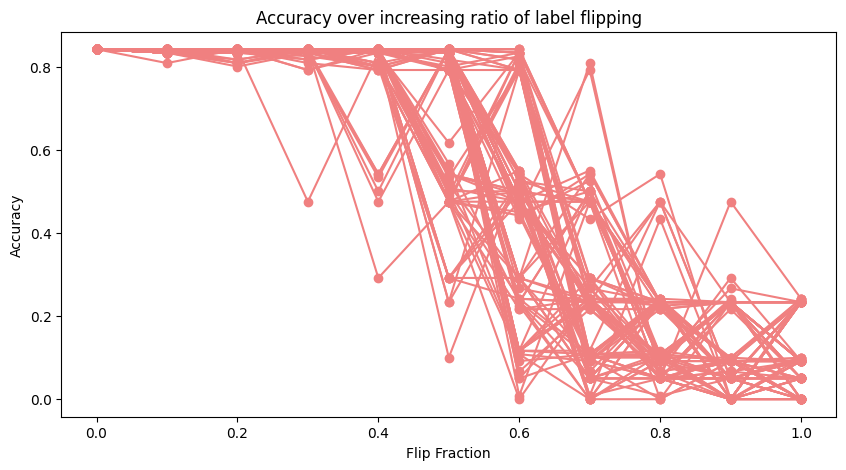

In [116]:
plot_accuracy_over_flip_fraction(100)

In [117]:
poisonedPipeline = AlteredPipeline(x_sample, y_sample)
poisonedPipeline.poison(num_target_classes, flip_fraction=.6)
poisonedPipeline.fit_predict(x_input)

print(poisonedPipeline.class_report(y_input_true))

              precision    recall  f1-score   support

      setosa       1.00      0.97      0.99        40
  versicolor       0.80      0.70      0.75        40
   virginica       0.74      0.85      0.79        40

    accuracy                           0.84       120
   macro avg       0.85      0.84      0.84       120
weighted avg       0.85      0.84      0.84       120



## Comparison

The label flipping in this semi-supervised approach causes drastical changes in performance, the accuracy (micro average for all the classes) dropping from around **80%** down to around **10%** to completely mess up the classification.

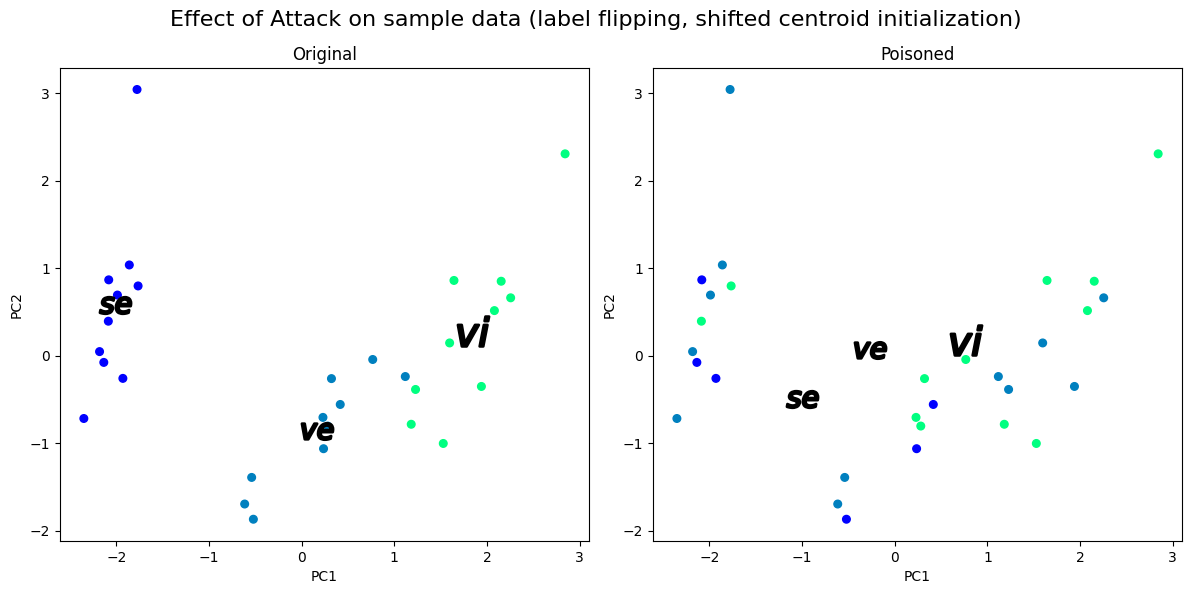

In [118]:
plot_effect_of_attack(x_sample, normalPipeline.initial_centroids, y_sample,
                      x_sample, poisonedPipeline.initial_centroids, poisonedPipeline.ySample,
                      title="Effect of Attack on sample data (label flipping, shifted centroid initialization)")

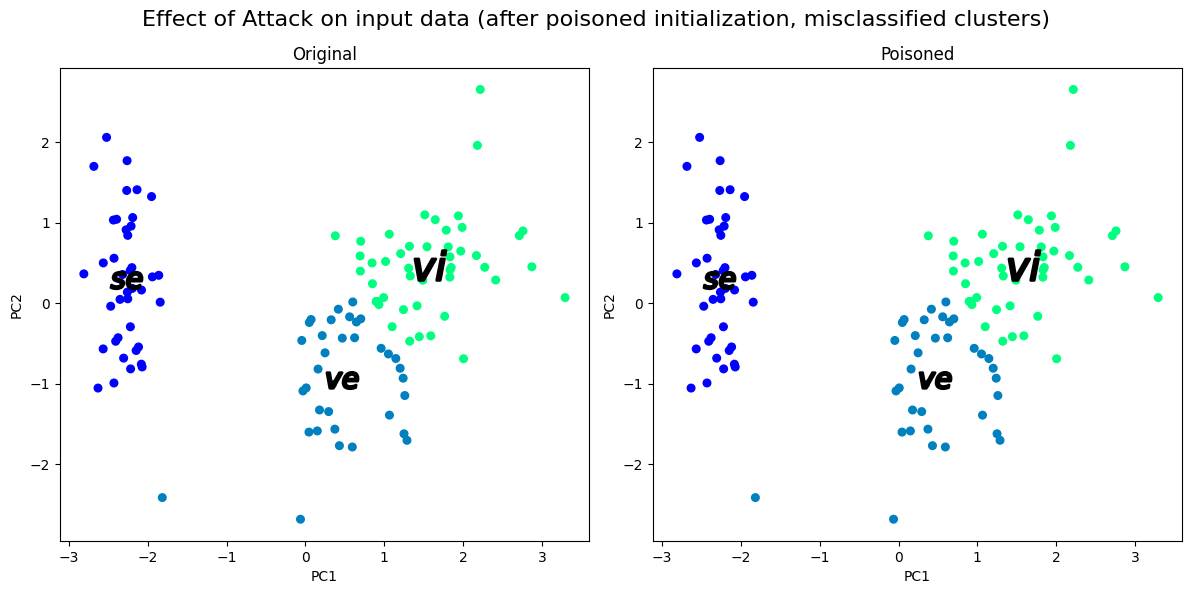

In [121]:
plot_effect_of_attack(x_input, normalPipeline.centroids, normalPipeline.pred,
                      x_input, poisonedPipeline.centroids, poisonedPipeline.pred,
                      title="Effect of Attack on input data (after poisoned initialization, misclassified clusters)")

In [122]:
print("Normal classification report:")
print(normalPipeline.class_report(y_input_true))

print()
print("Poisoned classification report:")
print(poisonedPipeline.class_report(y_input_true))

Normal classification report:
              precision    recall  f1-score   support

      setosa       1.00      0.97      0.99        40
  versicolor       0.80      0.70      0.75        40
   virginica       0.74      0.85      0.79        40

    accuracy                           0.84       120
   macro avg       0.85      0.84      0.84       120
weighted avg       0.85      0.84      0.84       120


Poisoned classification report:
              precision    recall  f1-score   support

      setosa       1.00      0.97      0.99        40
  versicolor       0.80      0.70      0.75        40
   virginica       0.74      0.85      0.79        40

    accuracy                           0.84       120
   macro avg       0.85      0.84      0.84       120
weighted avg       0.85      0.84      0.84       120



### Limitations

The poisoned model seems to be immune against label flipping of the sample data if the flip ratio is below $0.4$, according to accuracy. Also, below $0.7$, the poisoning effect is still questionable on average.